# Data Analysis Plan: Foreign Exchange Analysis

# Team 6
- Mahek Aggarwal
- John Gemmell
- Jacob Kulik
- David Pogrebitskiy


# Project Goal:
This Project aims to use exchangerate.host, a free foreign exchange and crypto API,
to understand how different currencies change and in relation to others and if a movement in
one can help predict a movement in another. By analysing trends and volatility, we will be able
to understand which currencies trigger a global movement, which ones tend to follow afterwards, and
be able to predict a currency's direction if we see a movement in a currency that it tracks.

# Data:
## Overview:

We will request Foreign Exchange values for a variety of different currencies and cryptos
from the ExchangeRate API. Our data will include both major and minor currencies that are pegged to/track
the currencies of first-world countries. Because the data coming from the API is in a time-series format,
we will be able to look at a variety of different period lengths between observations to see
which length best suits our needs.
# Pipeline Overview:
## API and Formating Functions:
- `api_req()`
    - makes an initial request to the API that includes time-series data of all of our
    desired parameters using Python's kwargs feature

- `merge_df_by_year()`
    - Merge multiple years worth of data into one dataframe because the API limits us
    to 2 years of data per call

## Analysis and Visualizations:
- `scale_cur()`
    - scales the currencies to be between 0 and 1, helping with plotting and analyzing
- `moving_avg()`
    - builds a moving function for a certain currency
- `calc_pct_change()`
    - calculating the percentage change between values, helping normalize an analysis

In [ ]:
import requests
from pprint import pprint
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler

import numpy as np
from sklearn.linear_model import LinearRegression
import pylab as py
import scipy.stats as stats
from sklearn.metrics import r2_score

In [ ]:
def api_req(**kwargs):
    '''
    This function calls an exchange rate api and builds a df with the data
    A list of strings (currencies) is a parameter
    returns a transpose dataframe where the dates are the indices

    Params for API call kwargs:
        start_date [required] String format (YYYY-MM-DD)
        end_date [required] String format (YYYY-MM-DD)
        base. example:base=USD
        symbols	[optional] Enter a list of comma-separated currency codes to limit output
            currencies. example:symbols=USD,EUR,CZK
        amount	[optional] The amount to be converted. example:amount=1200
        places	[optional] Round numbers to decimal place. example:places=2
        source	[optional] You can switch source data between (default) forex, bank view or crypto currencies. (ecb, crypto)
    '''

    params = kwargs
    url = 'https://api.exchangerate.host/timeseries?'
    
    # Query the API call
    response = requests.get(url, params=params)
    data = response.json()

    return pd.DataFrame(data['rates']).T

api_req(start_date='2021-01-01', end_date='2022-01-01', base='USD', symbols='GBP,RUB,EUR')

,EUR,GBP,RUB
2021-01-01,0.821300,0.731368,73.944993
2021-01-02,0.824063,0.731368,73.944989
2021-01-03,0.817388,0.731935,74.108816
2021-01-04,0.816286,0.736620,73.532982
2021-01-05,0.813219,0.734071,74.170118
...,...,...,...
2021-12-28,0.884210,0.744312,73.642400
2021-12-29,0.880921,0.741268,73.951951
2021-12-30,0.882704,0.740360,74.703970
2021-12-31,0.879286,0.739386,74.767039


In [ ]:
def merge_df_by_years(start_year, end_year, **kwargs):
    '''
    Creates a dataframe containing the exchange rates from the start year to the end year.
    Merge multiple years worth of data into one dataframe from the API call because it limits
    the amount of row in a request.
    :param start_year (int):
    :param end_year (int):
    
    :return: DataFrame
    '''

    df_output = pd.DataFrame()
    
    # Iterate through the the desired years
    for year in range(start_year, end_year + 1):
        params = {
            'start_date': f'{year}-01-01',
            'end_date': f'{year}-12-31',
        }
        # Update the params with the other input params
        kwargs.update(params)
        df_year = api_req(**kwargs)
        
        # Stack all the dataframes because of the API limitting
        df_output = pd.concat([df_output, df_year])
    df_output.dropna(inplace=True, axis=0)
    return df_output

df = merge_df_by_years(2010, 2022, symbols='GBP,EUR,RUB,JPY,AUD', base='USD') 
df

,JPY,GBP,RUB,AUD,EUR
2010-01-01,92.918694,0.618138,29.988881,1.113482,0.694927
2010-01-02,92.918694,0.618138,29.988881,1.113482,0.694927
2010-01-03,92.918694,0.618138,29.988881,1.113482,0.694927
2010-01-04,92.477815,0.620632,30.297421,1.095743,0.693289
2010-01-05,91.556453,0.625226,29.990185,1.096478,0.696088
...,...,...,...,...,...
2022-10-30,147.663565,0.861722,61.459182,1.562110,1.004753
2022-10-31,148.695328,0.872535,61.829863,1.561419,1.012303
2022-11-01,148.184337,0.871532,61.757949,1.564668,1.013211
2022-11-02,147.906184,0.878819,61.942221,1.575435,1.018859


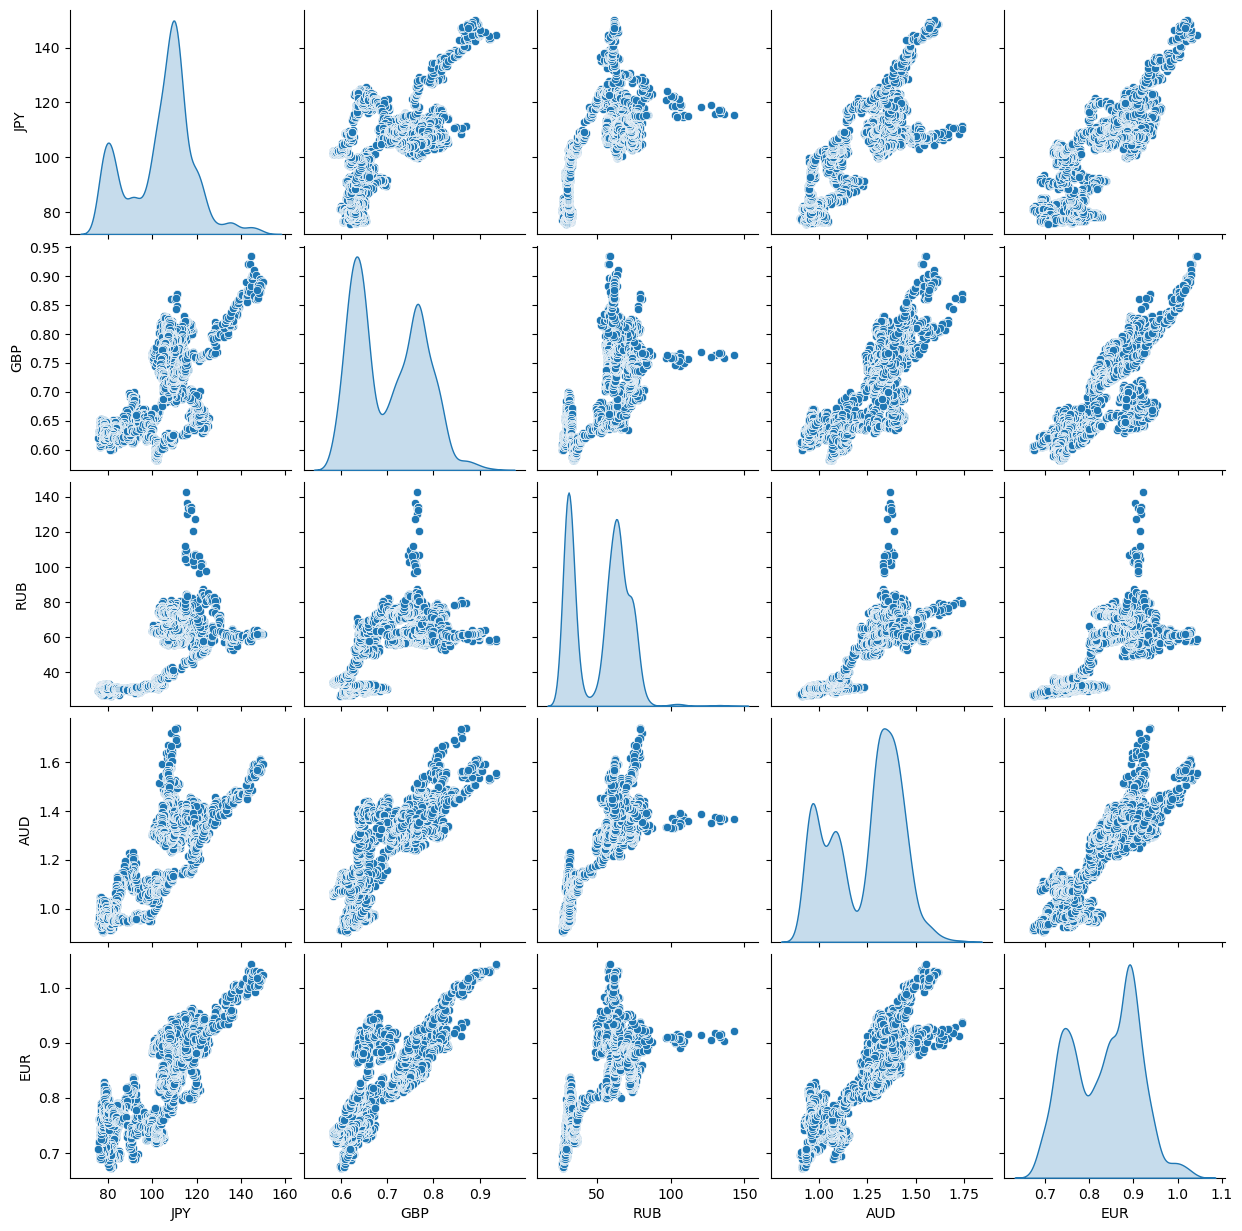

In [ ]:
sns.pairplot(df, diag_kind='kde')
plt.show()

In [ ]:
def scale_cur(df):
    '''
    Scales the exchange rates for a dataframe of currencies
    df- dataframe
    returns a scaled dataframe
    '''

    cols = df.columns
    # fitting a scaler to make the data comparable visually
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df.to_numpy())
    df_scaled = pd.DataFrame(df_scaled, columns=cols)

    # updating indexes to be dates
    df_scaled.index = df.index
    return df_scaled

df_scaled = scale_cur(df)
df_scaled

,JPY,GBP,RUB,AUD,EUR,GBP_avg,EUR_avg
2010-01-01,0.231092,0.100801,0.028231,0.248591,0.057518,NaN,NaN
2010-01-02,0.231092,0.100801,0.028231,0.248591,0.057518,NaN,NaN
2010-01-03,0.231092,0.100801,0.028231,0.248591,0.057518,NaN,NaN
2010-01-04,0.225159,0.107887,0.030892,0.227344,0.053085,NaN,NaN
2010-01-05,0.212761,0.120938,0.028243,0.228224,0.060660,NaN,NaN
...,...,...,...,...,...,...,...
2022-10-30,0.967764,0.792803,0.299624,0.785939,0.895971,0.956883,0.979053
2022-10-31,0.981647,0.823522,0.302820,0.785111,0.916403,0.954340,0.978312
2022-11-01,0.974771,0.820673,0.302200,0.789003,0.918860,0.951713,0.977586
2022-11-02,0.971028,0.841375,0.303789,0.801899,0.934144,0.951239,0.977724


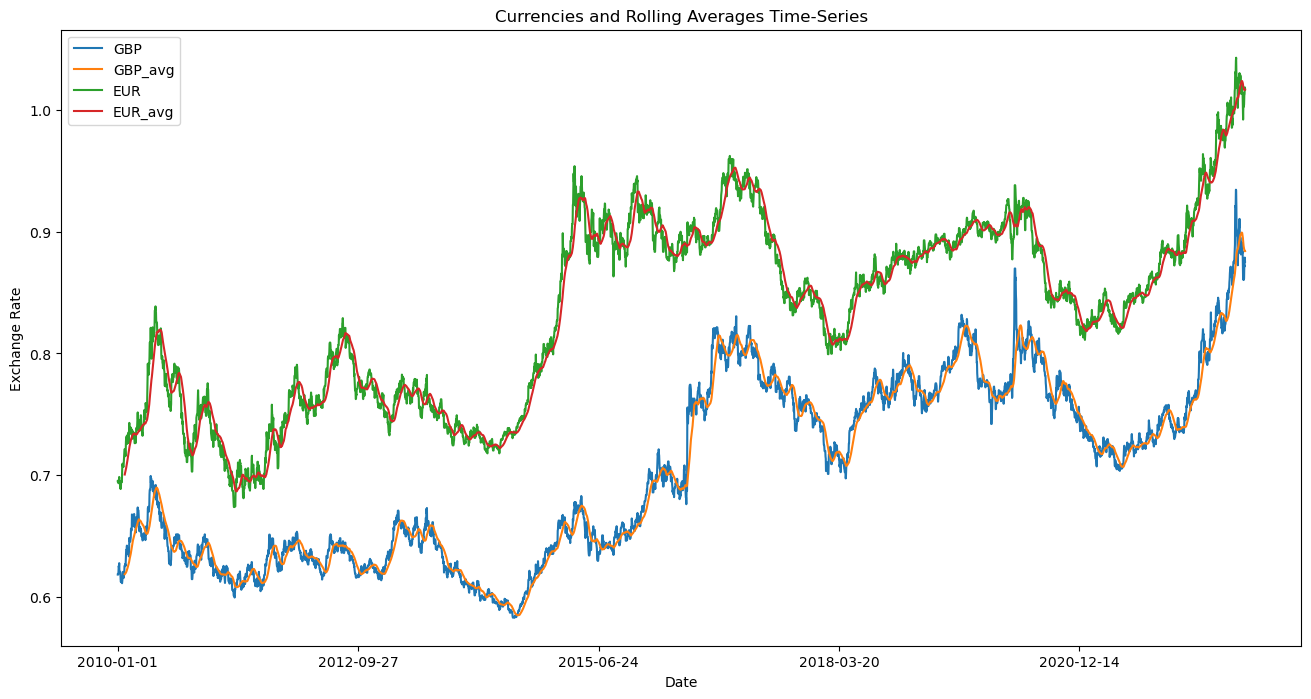

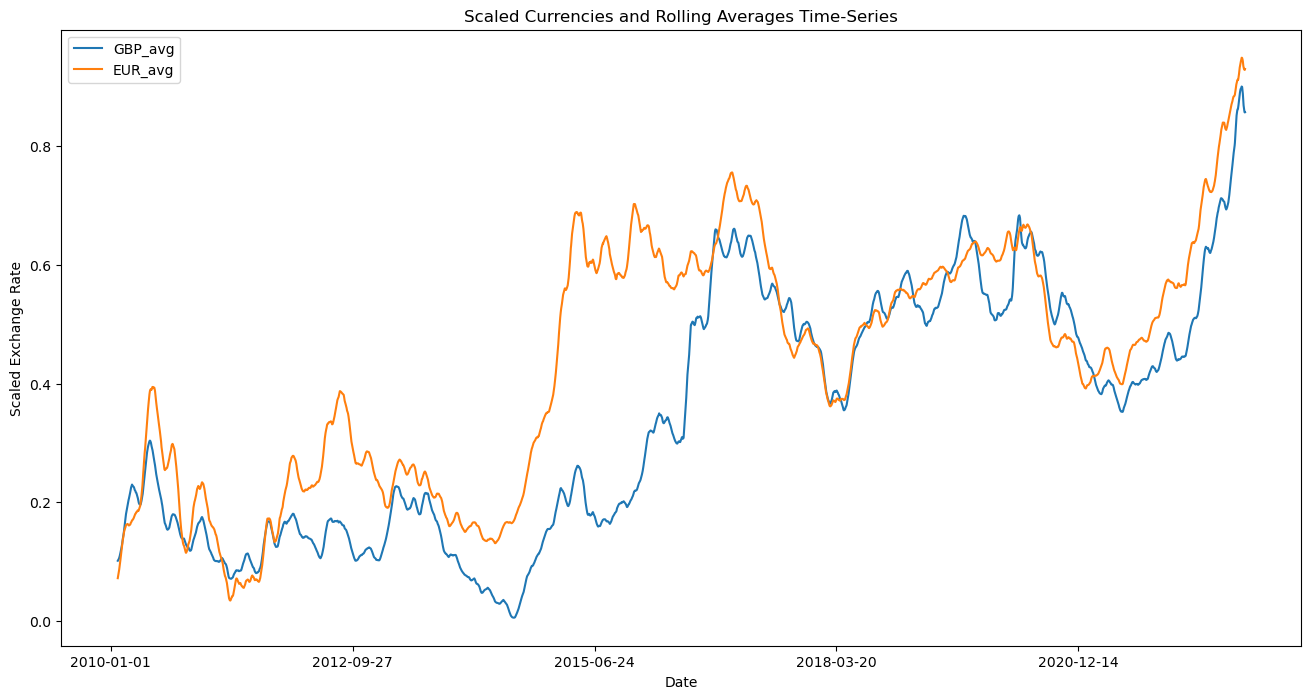

In [ ]:
def moving_avg(df, roll, *curs, scale=True):
    '''
    Creates a moving average plot for a given number of currencies and their moving averages
    df - dataframe, roll - int and number of days to be smoothed, *curs - list of currencies
    returns an updated df and a plot
    '''
    fig, ax = plt.subplots()

    # Creating label based off graph type
    plt.xlabel('Date')
    if scale:
        plt.ylabel('Scaled Exchange Rate')
        plt.title('Scaled Currencies and Rolling Averages Time-Series')
    else:
        plt.ylabel('Exchange Rate')
        plt.title('Currencies and Rolling Averages Time-Series')

    # iterating across currencies
    for cur in curs:
        cur_idx = cur + '_avg'
        # creating a rolling mean column and plotting both
        df[cur_idx] = df[cur].rolling(roll).mean()
        if scale:
            df[[cur_idx]].plot(ax=ax,label='ROLLING AVERAGE',
                                  figsize=(16, 8))
        else:
            df[[cur, cur_idx]].plot(ax=ax,label='ROLLING AVERAGE',
                                  figsize=(16, 8))
    return df

df_usd = moving_avg(df, 30,'GBP','EUR', scale=False)
df_usd_scaled = moving_avg(df_scaled, 30, 'GBP', 'EUR', scale=True)


In [ ]:
def calc_pct_change(df):
    """
    Calculates the pct change between each observation in the dataframe
    """
    pct_df = df.pct_change()
    
    # Rename each of the columns for the pct change
    for col in pct_df.columns:
        pct_df.rename(columns={col: col+"_pct_change"}, inplace=True)
    
    # Concat the original with pct change df
    return pct_df, pd.concat([df, pct_df], axis=1)

pct_df, pct_concated = calc_pct_change(df)

# Analysis Plan:

* We plan to analyze our time-series data of the currencies using different regression models such as linear regression, polynomial regression, and KNN regression and comparing these models to determine which one yields the best results for a predictive model.

* We can incorporate our scaled exchange rate info to make more sense of currency pegs and the fluctuation of excgange rates

* We can incorporate a cryptocurrency analysis as well, seeing how accurate different models are for crypto

* We also plan on analyzing the seasonality of how these currencies move to potentially see if we can identify any cycles that can help us predict a movement direction.

* Adding on, we can incoroprate more interactive plots, such as plotly dash, to allow a user to interact with our times-series data and play around with certain parameters

* Additionally, the correlation of various currencies can be calculated and analyzed to determine which currencies track with one another 

In [ ]:
sns.pairplot(pct_df.dropna(axis=0))
plt.show()

In [ ]:
def randomness_test(df, col1, col2):
    '''
    This function checks the independence of 2 columns of the percent change df
    Parameters: df - dataframe, col1 and col2 - strings with col names
    Returns x and y lists, slope and intercept floats, and makes plots
    '''
    #Checking Independence
    # getting rid of na vals and reshaping
    x_na = np.array(df[col1])
    x = x_na[np.logical_not(np.isnan(x_na))].reshape((-1, 1))
    
    # getting rid of na vals
    y_na = np.array(df[col2])
    y = y_na[np.logical_not(np.isnan(y_na))]
    
    reg = LinearRegression()
    reg.fit(x, y)

    # same as b_1
    slope = reg.coef_[0]

    # same as b_0
    intercept = reg.intercept_
    
    y_pred_bmg = slope * x + intercept
    
    # plotting using index and error vals
    errors = y.reshape((-1,1)) - y_pred_bmg
    plt.scatter(x = range(len(y)), y = errors)
    plt.xlabel('index')
    plt.ylabel('errors')
    plt.show()
    
    # Checking Constant Variance
    plt.scatter(x = x, y = errors)
    plt.xlabel(col1)
    plt.ylabel('errors')
    plt.show()
    
    # Checking Normality
    stats.probplot(errors.reshape((-1,)), dist="norm", plot=py)
    py.show()
    
    return x, y, slope, intercept

In [ ]:
def get_mse(y_true, y_pred):
    '''
    Calculates the mean squared distance between the predicted and actual y
    Takes 2 lists, y_true and y_pred
    Returns a mean squared error value
    '''
    # calculate the mean squared distance between the predicted and actual y
    return np.mean((y_pred - y_true) ** 2)

def show_fit(x, y, slope, intercept):
    '''
    This function creates a linear regression
    Parameters - x and y are lists, slope and intercept are floats
    Returns nothing, creates a linear regression plot
    '''
    plt.figure()
    
    # transform the input data into numpy arrays and flatten them for easier processing
    x = np.array(x).ravel()
    y = np.array(y).ravel()
    
    # plot the actual data
    plt.scatter(x, y, label='data')
    
    # compute linear predictions 
    # x is a numpy array so each element gets multiplied by slope and intercept is added
    y_pred = slope * x + intercept
    
    # plot the linear fit
    plt.plot(x, y_pred, color='black',
             ls=':',
             label='linear fit')
    
    # for each data point plot the error
    '''
    for idx, (x_i, y_i) in enumerate(zip(x, y)):
        plt.plot([x_i, x_i], [y_i, slope * x_i + intercept], 
                 ls='--', lw=3, color='tab:red',
                 label='error' if idx == 0 else "")
    '''
    plt.legend()
    
    plt.xlabel('x')
    plt.ylabel('y')
    
    # print the mean squared error
    y_pred = slope * x + intercept
    mse = get_mse(y_true=y, y_pred=y_pred)
    R2_easy = r2_score(y_true=y, y_pred=y_pred)
    plt.suptitle(f'y_hat = {slope:.2f} * x + {intercept:.5f}, RMSE = {mse**0.5:.3f}, R^2 = {R2_easy:.3f}')

In [ ]:
x, y, slope, intercept = randomness_test(pct_df, 'GBP_pct_change', 'EUR_pct_change')
show_fit(x, y, slope, intercept)